In [1]:
import nltk
import pandas as pd
import random
import numpy as np
import string
import math

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize

from numpy import array
from collections import Counter
from scipy.sparse import csr_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from gensim import corpora, models, utils
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.models import LsiModel
from gensim.corpora import Dictionary

import re

In [2]:
# Use spacy lib
# On https://spacy.io/

import spacy
nlp = spacy.load('fr')

In [171]:
##############
# Parameters #
##############

min_gram = 1
max_gram = 3

# To create ours partitions, we must first know the years which will be the limits
limit_years = [2007, 2010, 2014]

# Ignore words that appear at a frequency less than max_frequ in the corpus
max_frequ = 0.2

# Ignore words appearing less than min_appear in the whole corpus
min_appear = 5

# Number of clusters by partitions
nb_clusters = 5

In [172]:
# Datas preprocessing methods.

# Lemmatisation without poncutations

stemmer = nltk.stem.snowball.FrenchStemmer()
fstw = stopwords.words('french')

# French Stop Words, extraits depuis le fichier stopwords-fr.txt + stopwords french de nltk
sourceFST = [x.replace('\n', '') for x in open('stopwords-fr.txt', mode="r", encoding="utf-8").readlines()]+fstw
sourceFST += [x.replace('\n', '') for x in open('perso_words-fr.txt', mode="r", encoding="utf-8").readlines()]

# Based on ration of french and english stopwords
def isEnglish(article):
    total_fsw = len([x for x in article.split() if x in sourceFST])
    total_esw = len([x for x in article.split() if x in stopwords.words('english')])
    ratio = 100
    if total_fsw != 0:
        ratio = total_esw/total_fsw
    return ratio > 1 and total_esw > 3

def lemmatize(article):
    arti_lower = article.lower()
    arti_2words = re.sub(" [0-z][0-z] ", " ", arti_lower) # word of length < 2
    arti_e = re.sub("(é|è|ê)", "e", arti_2words)
    arti_o = re.sub("à", "a", arti_e)
    arti_i = re.sub("ô", "o", arti_o)
    artiregex = re.sub("î", "i", arti_i)
    output = []
    outPonc = artiregex.translate(artiregex.maketrans("","", string.punctuation))
    outLem = nlp(outPonc)
    for token in outLem:
        if token.lemma_ not in sourceFST and [x for x in token.lemma_ if x not in "0123456789"] != []:
            output.append(token.lemma_)
    res = ' '.join(output)
    return res

In [173]:
# Data Reading
data = pd.read_csv('export_articles_EGC_2004_2018.csv', sep='\t', header=0)

In [174]:
# Let's process our corpus, and determine a limit to split it in partitions

# usable[] correspond to our corpus processed
# limits[] let us know when to delimit partitions
limits = []
usable = []

prev_year = data['year'][0]
numArti = 0
for i in range(0, len(data['abstract']), 1):
    #if not null, empty, or whatever (so if there is a abstract):
    if not isinstance(data['abstract'][i], float) and not isEnglish(data['abstract'][i]):
        text = data['abstract'][i]
        if not isinstance(data['title'][i], float):
            text += " "+data['title'][i]

        numArti+=1
        usable.append(re.sub(" [0-z][0-z] ", " ", stemmer.stem(lemmatize(text))))
        year = data['year'][i]
        if year != prev_year:
            prev_year = year
            if year in limit_years:
                limits.append(numArti)
limits.append(numArti)



In [175]:
# Display pre-processed datas

vectorizer = TfidfVectorizer(stop_words=sourceFST, use_idf=True, ngram_range=(min_gram, max_gram), max_df=max_frequ, min_df=min_appear)
tfidf = vectorizer.fit_transform(usable)

print("nombre d'articles =", len(usable))
print("nombre de mots =", len(tfidf.toarray()[0]))
print("limits =", limits)

usable[1]

/usr/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  sorted(inconsistent))


nombre d'articles = 991
nombre de mots = 2395
limits = [223, 468, 694, 991]


'classification croise coclustering technique permettre dextraire structuresousjacente existant entrer ligne colonne tabler donneer sou former bloc application utiliser technique algorithme coclustering actuel passer lechelle approche utilise succe method modl optimiser critere vraisemblance regularisee cependent taille plaire important methode atteindre limiter article presenter nouvel algorithme coclustering niveau compter critere modl permettre traiter efficacement donnee grand tailler pouvoir memoir experience montrer lapproche propose gagn temps calcul produire solution qualite two level coclustering algorithm for very large dater set'

In [176]:
# Creation of partitions_tfidf[], which give us the TFIDF of each cluster of each partition
# partitions_tfidf[num_partition][num_doc][num_word]
# Beware, num_doc can't be equals to 1091 (max). You have partitions, so every doc aren't in every partitions
# num_word can be found via vectorizer.get_feature_name()
partitions_tfidf = []
beg = 0
for l in limits:
    last = l
    partitions_tfidf.append([list(x) for x in list(tfidf.toarray())[beg:last]])
    beg = l

In [177]:
vectorizer.get_feature_names()

['acce',
 'accessible',
 'achat',
 'acquisition',
 'acquérir',
 'acteur',
 'actif',
 'action',
 'activite',
 'actuel',
 'actuellement',
 'adapt',
 'adaptatif',
 'adaptation',
 'adapte',
 'adaptee',
 'adapter',
 'adequat',
 'adn',
 'adopter',
 'afc',
 'affiner',
 'agent',
 'agregation',
 'aid',
 'aider',
 'ainsiqu',
 'ajoutee',
 'ajouter',
 'ala',
 'aleatoir',
 'algebriqu',
 'algorithm',
 'algorithm classification',
 'algorithm dapprentissage',
 'algorithm dextraction',
 'algorithm efficace',
 'algorithme',
 'algorithme dapprentissage',
 'algorithme dextraction',
 'algorithme ete',
 'algorithme fouiller',
 'algorithme incremental',
 'algorithmique',
 'alignement',
 'alternatif',
 'amelior',
 'amelioration',
 'ameliore',
 'amelioree',
 'ameliorer',
 'ameliorer qualite',
 'amene',
 'amont',
 'analys',
 'analyse',
 'analyser',
 'analyser donnee',
 'analyser factoriel',
 'analyser semantiqu',
 'analytique',
 'anne',
 'annees',
 'annot',
 'annotation',
 'annotation semantiqu',
 'annoter',
 '

# KMeans

In [178]:
# Applying KMeans on tfidf
# the labels_ give assignment of doc to the cluster number 
km = KMeans(n_clusters=nb_clusters, max_iter=1000, init='k-means++')
km.fit(tfidf)
cluster = km.labels_
cluster_centers = km.cluster_centers_

cluster_partition = [cluster[:limits[0]],cluster[limits[0]:limits[1]],cluster[limits[1]:limits[2]],cluster[limits[2]:limits[3]]]

In [179]:
part_km = []
for i in range(0, len(limits)):
    dash = km.fit(partitions_tfidf[i])
    part_km.append(dash)

In [180]:
#(part_km[1]).labels_
#
#all_labels = []
#for i in range(0,len(limits)):
#    for j in range(0, len((part_km[i]).labels_)):
        

In [181]:
# doc_clustering is a dictionnary 
# it looks like -> { doc_number : [partition_number, cluster_number] }
# This is used to reassign doc number to their respective partition and and cluster
doc_clustering = {}
for i in range(0,len(usable)):
    if i < limits[0]:
        doc_clustering[i] = [0, cluster[i]]
    elif i >= limits[0] and i < limits[1]:
        doc_clustering[i] = [1, cluster[i]]
    elif i >= limits[1] and i < limits[2]:
        doc_clustering[i] = [2, cluster[i]]
    else:
        doc_clustering[i] = [3, cluster[i]]

In [182]:
# Allows to get list of documents number
# return [dou numbers]
# params : partition_number , cluster number
partitions = []
def get_doc(part, clust):
    docs = []
    for i in range(0,len(doc_clustering)):
        if doc_clustering[i][0] == part and doc_clustering[i][1] == clust:
            docs.append(i)
    return docs

In [183]:
# Get the partitions variable
# Here partitions[part][cluster] = list of docs numbe
partitions = []
for i in range(0, len(limits)):
    clusters = []
    for j in range(0, nb_clusters):
        clusters.append(get_doc(i,j))
    partitions.append(clusters)

In [184]:
# example of output for doc_clustering
# doc 465 is in cluster 1 of the partition 1
# doc 154 is in cluster 2 of the partition 0

print(doc_clustering[465])
print(doc_clustering[154])
print()

# Here, just count docs number by cluster.
print(Counter(cluster_partition[0]))
print(Counter(cluster_partition[1]))
print(Counter(cluster_partition[2]))
print(Counter(cluster_partition[3]))

[1, 1]
[0, 2]

Counter({3: 134, 2: 33, 1: 26, 4: 16, 0: 14})
Counter({3: 121, 2: 52, 1: 35, 4: 21, 0: 16})
Counter({3: 116, 2: 44, 1: 41, 0: 13, 4: 12})
Counter({3: 139, 1: 55, 2: 54, 0: 32, 4: 17})


# Quality Measure

In [185]:
# SOURCE :
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


# Silhouette analysis can be used to study the separation distance between the resulting clusters.
# The silhouette plot displays a measure of how close each point in one cluster is to points in 
# the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.
# This measure has a range of [-1, 1].

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For partition = 0 The average silhouette_score is : 0.00516844713774457
For partition = 1 The average silhouette_score is : 0.010811358494442962
For partition = 2 The average silhouette_score is : 0.009427314936782076
For partition = 3 The average silhouette_score is : 0.01158513924186405


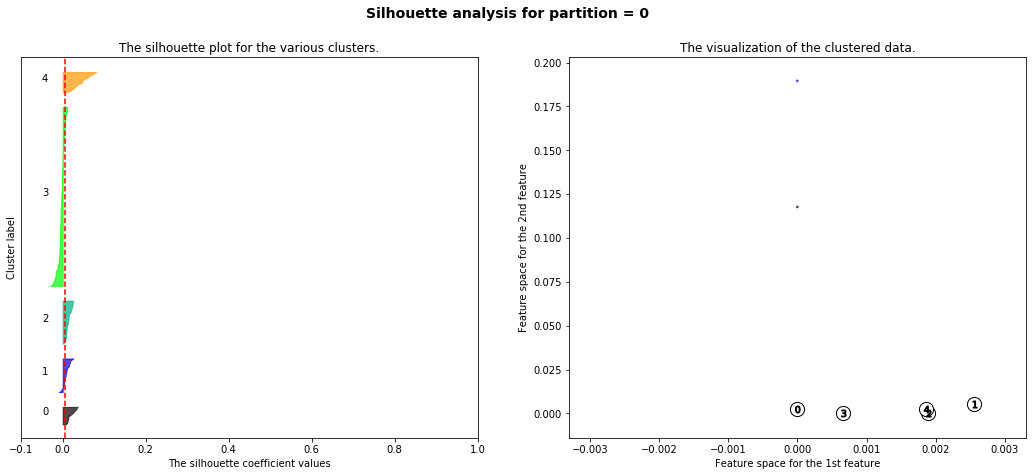

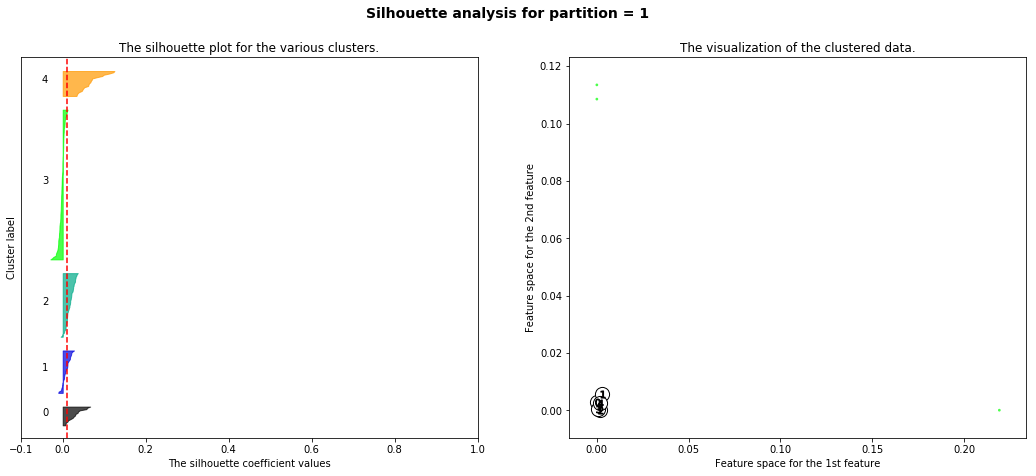

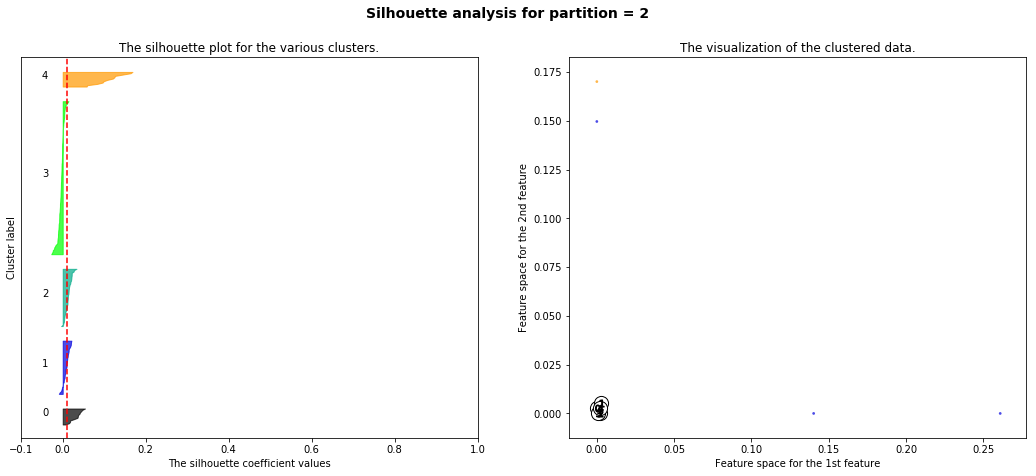

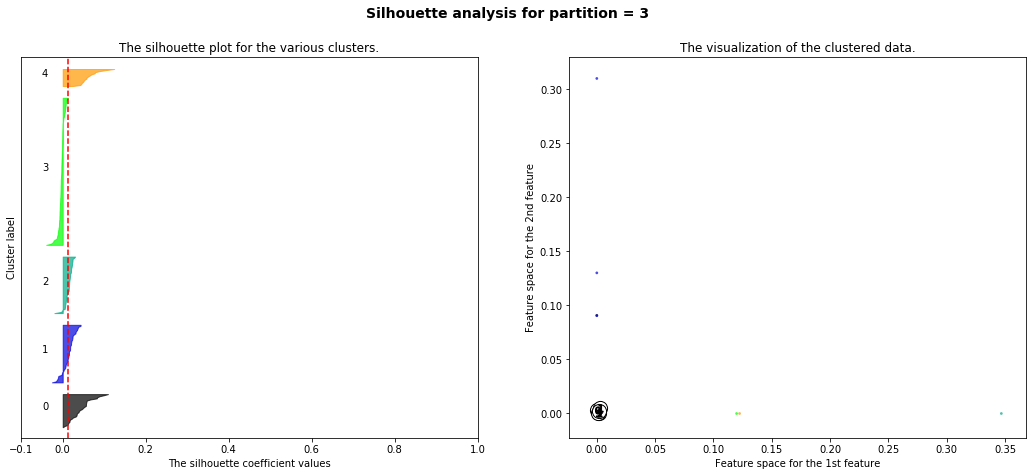

In [186]:
#param
nb_partitions = 4

for n_partition in range(nb_partitions):
    partition_tfidf = np.asarray(partitions_tfidf[n_partition])
    partition_labels = np.asarray(cluster_partition[n_partition])
    
    silhouette_avg = silhouette_score(partition_tfidf, partition_labels)
    sample_silhouette_values = silhouette_samples(partition_tfidf, partition_labels)
    print("For partition =", n_partition,
          "The average silhouette_score is :", silhouette_avg)
    
    
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(partition_tfidf) + (nb_clusters + 1) * 10])

    y_lower = 10
    for i in range(nb_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[partition_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nb_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(partition_labels.astype(float) / nb_clusters)
    ax2.scatter(partition_tfidf[:, 0], partition_tfidf[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(cluster_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for partition = %d" % n_partition),
                 fontsize=14, fontweight='bold')

# Khi²

In [18]:
# tf_of_your_word = tf[numDoc][strWord]
tf = []
for doc in usable:
    tf_doc = {}
    for word in vectorizer.get_feature_names():
        tf_doc[word] = doc.count(word)
    tf.append(tf_doc)

In [19]:
# Number total of words
# nb_total_word[numPartition]
nb_total_word = []
nb = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        nb += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_total_word.append(nb)
        nb=0
    

In [20]:
nb_total_word

[26871, 29619, 26638, 36296]

In [21]:
tf[0]

{'acce': 0,
 'accessible': 0,
 'achat': 0,
 'acquisition': 0,
 'acquérir': 0,
 'acteur': 0,
 'actif': 0,
 'action': 0,
 'activite': 0,
 'actuel': 0,
 'actuellement': 0,
 'adapt': 0,
 'adaptatif': 0,
 'adaptation': 0,
 'adapte': 0,
 'adaptee': 0,
 'adapter': 0,
 'adequat': 0,
 'adn': 0,
 'adopter': 0,
 'afc': 0,
 'affiner': 0,
 'agent': 0,
 'agregation': 0,
 'aid': 0,
 'aider': 0,
 'ainsiqu': 0,
 'ajoutee': 0,
 'ajouter': 0,
 'ala': 0,
 'aleatoir': 0,
 'algebriqu': 0,
 'algorithm': 0,
 'algorithm classification': 0,
 'algorithm dapprentissage': 0,
 'algorithm dextraction': 0,
 'algorithm efficace': 0,
 'algorithme': 0,
 'algorithme dapprentissage': 0,
 'algorithme dextraction': 0,
 'algorithme ete': 0,
 'algorithme fouiller': 0,
 'algorithme incremental': 0,
 'algorithmique': 0,
 'alignement': 0,
 'alternatif': 0,
 'amelior': 0,
 'amelioration': 0,
 'ameliore': 0,
 'amelioree': 0,
 'ameliorer': 0,
 'ameliorer qualite': 0,
 'amene': 0,
 'amont': 0,
 'analys': 2,
 'analyse': 2,
 'analyser

In [22]:
# nb_word[num_partition][word]
nb_word = []

word_in_this_parti = {}
for word in vectorizer.get_feature_names():
    word_in_this_parti[word] = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        word_in_this_parti[word] += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_word.append(word_in_this_parti)
        word_in_this_parti = {}
        for word in vectorizer.get_feature_names():
            word_in_this_parti[word] = 0

In [23]:
len(nb_word)

4

In [24]:
# nb_word_by_cluster[numPartition][numCluster]
nb_word_by_cluster = []
for parti in partitions:
    nb_word_clus = []
    for cluster in parti:
        nb = 0
        for numDoc in cluster:
            for word in vectorizer.get_feature_names():
                nb += tf[numDoc][word]
        nb_word_clus.append(nb)
    nb_word_by_cluster.append(nb_word_clus)

In [25]:
# Expected values, if nothing were dependant
# exp[numPartition][numCluster][numWord]
#exp = []
#for numParti in range(0, len(partitions)):
#    exp_clus = []
#    for numCluster in range(0, len(partitions[numParti])):
#        exp_word = []
#        for numWord in range(0, vectorizer.get_feature_names()):
#            exp_word.append((nb_word[numParti][numWord] + nb_word_by_cluster[numPart][numCluster]) / nb_total_word[numParti])
#        exp_cluster.append(exp_word)
#    exp.append(exp_clus)


In [26]:
# value_of_khi2 = khi2[numPartition][numCluster][word]
khi2 = []

for numParti in range(0, len(partitions)):
    khi2parti = []
    for numCluster in range(0, len(partitions[numParti])):
        khi2cluster = {}
        
        for word in vectorizer.get_feature_names():
            word_in_this_parti[word] = 0
            E = nb_word[numParti][word]
            E =+ nb_word_by_cluster[numParti][numCluster]
            E = E/ nb_total_word[numParti]
            N = 0
            for numDoc in partitions[numParti][numCluster]:
                N += tf[numDoc][word]
            khi2cluster[word] = (pow(N - E, 2)/E)        
        khi2parti.append(khi2cluster)
    khi2.append(khi2parti)

In [27]:
# list of your labels = labels[numPartition][numCluster]
labels = []

for numPartition in range(0, len(nb_word_by_cluster)):
    label_clus = []
    for numCluster in range(0, len(nb_word_by_cluster[numPartition])):
        label_clus.append(Counter(khi2[numPartition][numCluster]).most_common(5))
    labels.append(label_clus)